In [1]:
import numpy as np
import pandas as pd
from numpy import count_nonzero
import matplotlib.pyplot as plt
import scipy.sparse as ss
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn import tree
from tabulate import tabulate

In [2]:
#load data, in sparse format
def load_data(filename):
    f = open('dorothea/%s.data' % filename)
    I,J = [],[]
    for k in range(100000):
        line = f.readline()
        if len(line) == 0:
            print ('done')
            break

        line = [int(x) for x in line.split()]
        J.extend(line)
        I.extend(k for i in range(len(line)))

    return ss.coo_matrix((np.ones(len(I)), (I,J)))


def load_labels(filename):
    f = open('dorothea/%s.labels' % filename)
    y = []
    for k in range(100000):
        line = f.readline()
        
        if len(line) == 0:
            print('done')
            break
        y.append(int(line))
    return np.array(y)


Xtrain = load_data('dorothea_train')
ytrain = load_labels('dorothea_train')

Xtest= load_data('dorothea_valid')
ytest = load_labels('dorothea_valid')

print(Xtrain.shape,  Xtest.shape, Xtrain.nnz)

done
done
done
done
(800, 100001) (350, 100001) 727760


## Q1) Sparsity

In [3]:
xTrainNumpy = Xtrain.todense()
print(ytrain.shape,  xTrainNumpy.shape, Xtrain.nnz)

(800,) (800, 100001) 727760


In [4]:
ss.coo_matrix(Xtrain)

<800x100001 sparse matrix of type '<class 'numpy.float64'>'
	with 727760 stored elements in COOrdinate format>

In [5]:
xTrainNumpy = Xtrain.todense()
sparsity = 1.0 - (Xtrain.nnz / float(xTrainNumpy.size) )
print("Number of Zero Elements: "+ str(xTrainNumpy.size - count_nonzero(xTrainNumpy)))
print("Number of Non Zero Elements: "+ str(Xtrain.nnz))
print("Sparsity : % 0.3f" %(sparsity))

Number of Zero Elements: 79273040
Number of Non Zero Elements: 727760
Sparsity :  0.991


In [6]:
def get_class_balance(y):
    uniqueValues, counts = np.unique(y,return_counts=True)
    total = np.shape(y)[0]
    positiveValues = 0
    negativeValues = 0
    for index, value in enumerate(uniqueValues):
        if value == 1:
            positiveValues = counts[index]
        else:
            negativeValues = counts[index]
    assert(positiveValues+negativeValues == total), "Something wrong please check"
        
    return positiveValues/total, negativeValues/total

print ('Training class balance is currently %.2f  +1, %.2f -1' % get_class_balance(ytrain))
print ('Test class balance is currently %.2f  +1, %.2f -1' % get_class_balance(ytest))

Training class balance is currently 0.10  +1, 0.90 -1
Test class balance is currently 0.10  +1, 0.90 -1


## Q2 comments on class_balance and sparsity

1) dorothea datset is highly imbalanced dataset with only 10% positives (rare events) and 90& normal events.

This is the same for both training and test sets.

2) The dataset is highly sparsed, it has 99.1 % of elements as zeros and only 0.9% non-zero elements.

3) The number of training examples in this dataset is almost of the same order as compared to covtype dataset (800 vs 468)
but the number of features in dorothea dataset is 100,000 as compared to only 54 features in covtype dataset.

In [7]:
def get_misclass(y,yhat):
    incorrect = 0
    totalSamples = len(y)
    for i in range(totalSamples):
        if y[i] != yhat[i]:
            incorrect += 1
    return incorrect / totalSamples
    
def get_f1(y,yhat):
    totalSamples = len(y)
    truePostives = 0
    trueNegatives = 0
    falsePositives = 0
    falseNegatives = 0
    
    for i in range(totalSamples):
        if y[i] == 1 and yhat[i] == 1:
            truePostives +=1
        elif y[i] == -1 and yhat[i] == -1:
            trueNegatives +=1
        elif y[i] == -1 and yhat[i] == 1:
            falsePositives +=1
        elif y[i] == 1 and yhat[i] == -1:
            falseNegatives +=1

    precision = truePostives/(truePostives + falsePositives)
    recall = truePostives/(truePostives + falseNegatives)
    
    assert((truePostives + trueNegatives + falsePositives + falseNegatives) == totalSamples),"something is wrong"
    return (2 * (precision* recall))/(precision + recall)

depth = 3
clf = tree.DecisionTreeClassifier(criterion='entropy',
                                  splitter='best',
                                  max_depth=depth, 
                                  class_weight='balanced')
clf = clf.fit(Xtrain, ytrain)

print(get_misclass(ytrain, clf.predict(Xtrain) ), get_f1(ytrain, clf.predict(Xtrain)))

0.04125 0.7724137931034484


### Verification with in-built methods

In [8]:
yPredTrain = clf.predict(Xtrain)
yPredTest = clf.predict(Xtest)

results = []
results.append(("train",
                get_misclass(ytrain, yPredTrain), 
                1 - accuracy_score(ytrain, yPredTrain), 
                get_f1(ytrain, yPredTrain),
                f1_score(ytrain, yPredTrain)))

results.append(("test",
                get_misclass(ytest, yPredTest), 
                1 - accuracy_score(ytest, yPredTest), 
                get_f1(ytest, yPredTest),
                f1_score(ytest, yPredTest)))

columns = ['dataset',
           'missclassification-score (custom)',
           'missclassification-score (in-built)',
           'F1-score (custom)',
           'F1-score (in-built)',]

pd.set_option("display.max_colwidth",2)
df = pd.DataFrame(results, columns=columns)
df.set_index('dataset')
df

,dataset,missclassification-score (custom),missclassification-score (in-built),F1-score (custom),F1-score (in-built)
0,train,0.041250,0.041250,0.772414,0.772414
1,test,0.071429,0.071429,0.603175,0.603175


## Comments about Misclassification score vs F1 Score

1) **F1 score** is a **better** metric than **misclassification score** for this task.

**Reason**: The classes are **highly imbalanced**, even if we say every event id not a rare-event, we would get a misclassification score of 0.1.

So, using F1 score is a better metric, as it gives weightage for both precision and recall and gives a good evaluation metric for our model,

## Without any cross-validation

In [9]:
def getF1ScoreAndPlot(Xtrain,ytrain,Xtest,ytest):
    depth   = list(range(2,11))
    results = [] 
    for d in depth:
        clf = tree.DecisionTreeClassifier(criterion='entropy',
                                          splitter='best',
                                          max_depth=d, 
                                          class_weight='balanced')
        clf = clf.fit(Xtrain, ytrain)
        yPredTrain = clf.predict(Xtrain)
        yPredTest = clf.predict(Xtest)
        results.append([d,
                       get_f1(ytrain, yPredTrain),
                       get_f1(ytest, yPredTest),
                       ])
    columns = ['depth',              
               'F1-score (train)',
               'F1-score (test)',]

    pd.set_option("display.max_colwidth",2)
    df = pd.DataFrame(results, columns=columns)

    print(tabulate(df.set_index('depth'), headers='keys', tablefmt='psql'))

    trainF1 = [resultsAtAGivenDepth[1] for resultsAtAGivenDepth in results]
    testF1  = [resultsAtAGivenDepth[2] for resultsAtAGivenDepth in results]


    plt.figure(figsize=(14,8))
    x = depth # Create domain for plot
    plt.plot(x, trainF1, label='Training F1 Score') # Plot training error over domain
    plt.plot(x, testF1, label='Testing F1 Score') # Plot testing error over domain
    plt.xlabel('Maximum Depth',fontsize=12) # Label x-axis
    plt.ylabel('F1 Score',fontsize=12) # Label y-axis
    plt.title('Depth Vs F1 Score(Test and Train) Without any cross-Validation',fontsize=18) # Label y-axis
    plt.legend() # Show plot labels as legend
    plt.show()
    return df

+---------+--------------------+-------------------+
|   depth |   F1-score (train) |   F1-score (test) |
|---------+--------------------+-------------------|
|       2 |           0.713287 |          0.6      |
|       3 |           0.772414 |          0.580645 |
|       4 |           0.824324 |          0.615385 |
|       5 |           0.872483 |          0.571429 |
|       6 |           0.906667 |          0.626866 |
|       7 |           0.934211 |          0.483871 |
|       8 |           0.91358  |          0.597015 |
|       9 |           0.974359 |          0.571429 |
|      10 |           0.975    |          0.575758 |
+---------+--------------------+-------------------+


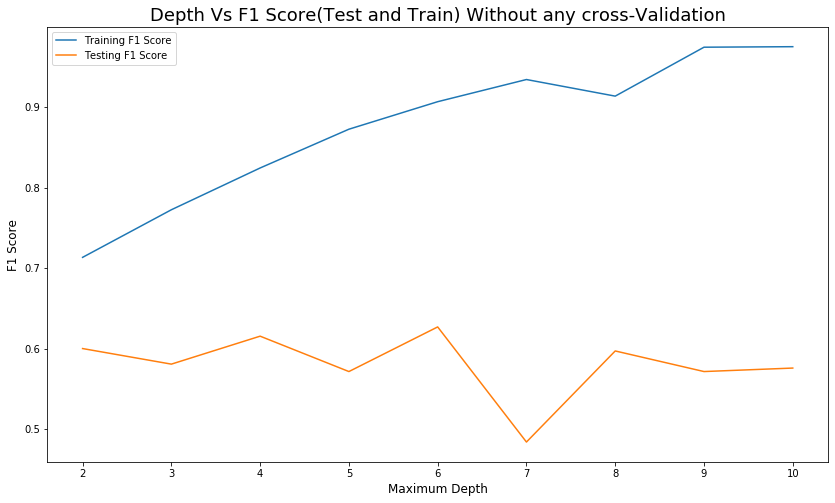

In [10]:
testF1ScoresWithoutValidation = getF1ScoreAndPlot(Xtrain,ytrain,Xtest,ytest)

## K-fold cross-validation (k=5)

In [11]:
import random
randomIndices = random.sample(range(800), 800)
xSplit = []
ySplit = []
for i in range(5):
    randomRowIndices = randomIndices[(i*160):(i*160)+160]
    xSplit.append(xTrainNumpy[randomRowIndices])
    ySplit.append(ytrain[randomRowIndices])

In [12]:
def prepareTrainSetForKFoldCV(xTrain,yTrain,indexOfTheValidation):
    assert np.shape(xSplit) == (5,160,100001), "Check xTrain"
    assert np.shape(ySplit) == (5,160), "Check yTrain"
    xTrainWithoutValidationSet = []
    yTrainWithoutValidationSet = []
    for index in range(5):
        if index!=i:
            if len(xTrainWithoutValidationSet) == 0:
                xTrainWithoutValidationSet = xTrain[index]
                yTrainWithoutValidationSet = yTrain[index]
            else:
                xTrainWithoutValidationSet = np.concatenate([xTrainWithoutValidationSet,xTrain[index]])
                yTrainWithoutValidationSet = np.concatenate([yTrainWithoutValidationSet,yTrain[index]])
    return xTrainWithoutValidationSet, yTrainWithoutValidationSet    

In [13]:
def buildTreeAndgetF1Score(Xtrain,ytrain,
                           XValidation,YValidation, 
                           i,d):
    
    clf = tree.DecisionTreeClassifier(criterion='entropy',
                                          splitter='best',
                                          max_depth=d, 
                                          class_weight='balanced')
    clf = clf.fit(Xtrain, ytrain)
    yPredTrain      = clf.predict(Xtrain)
    yPredValidation = clf.predict(XValidation)    
    return  get_f1(ytrain, yPredTrain), get_f1(YValidation, yPredValidation)

In [14]:
depth   = list(range(2,11))
allValidationF1Scores   = []
averageValidationScores = []
allResults = []
for d in depth:
    results = []    
    for i in range(5):
        XTrain,yTrain = prepareTrainSetForKFoldCV(xSplit,ySplit,i)
        XValidation = xSplit[i]
        YValidation = ySplit[i]
        trainF1Score, validationF1Score = buildTreeAndgetF1Score(XTrain,yTrain,
                                                                 XValidation,YValidation,                                                                
                                                                 i,d)
        allValidationF1Scores.append(validationF1Score)
        results.append([d,
                        i+1,
                        trainF1Score,                         
                        validationF1Score])
        allResults.append([d,
                        i+1,
                        trainF1Score,
                        validationF1Score])
        columns = ['depth',
                   'iteration in k-fold-cv',
                   'F1-score (train)',                   
                   'F1-score (validation)']
        df = pd.DataFrame(results, columns=columns)
    averageValidationScores.append(df['F1-score (validation)'].mean())    
    print(tabulate(df.set_index('depth'), headers='keys', tablefmt='psql'))

+---------+--------------------------+--------------------+-------------------------+
|   depth |   iteration in k-fold-cv |   F1-score (train) |   F1-score (validation) |
|---------+--------------------------+--------------------+-------------------------|
|       2 |                        1 |           0.730435 |                0.571429 |
|       2 |                        2 |           0.725664 |                0.545455 |
|       2 |                        3 |           0.717949 |                0.608696 |
|       2 |                        4 |           0.736842 |                0.62069  |
|       2 |                        5 |           0.696429 |                0.774194 |
+---------+--------------------------+--------------------+-------------------------+
+---------+--------------------------+--------------------+-------------------------+
|   depth |   iteration in k-fold-cv |   F1-score (train) |   F1-score (validation) |
|---------+--------------------------+----------------

## Plot the F1 score over the validation set for all K trials.

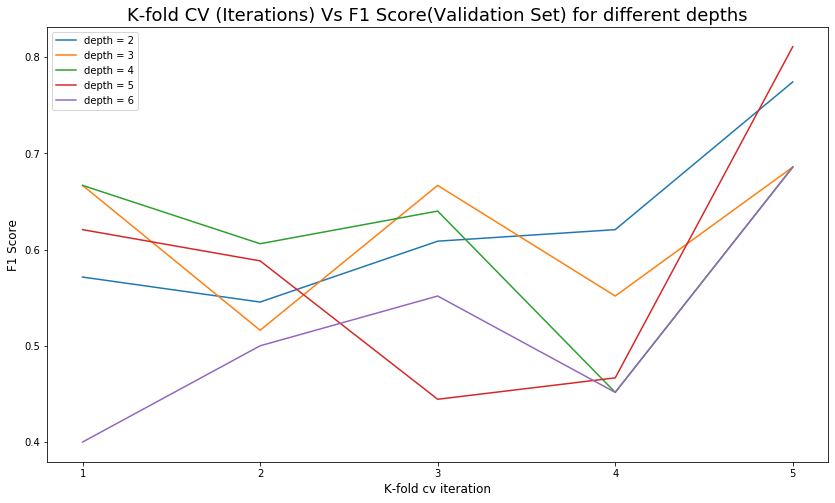

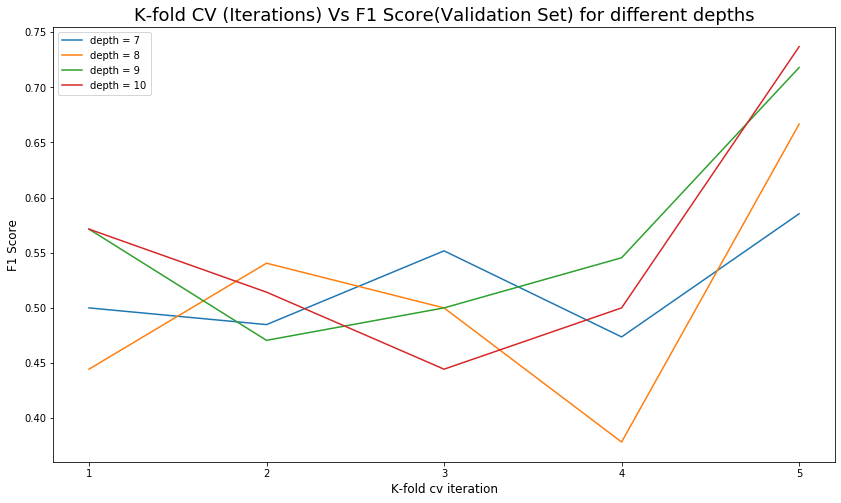

In [15]:
validationScoresByDepth = [allValidationF1Scores[i:i + 5] for i in range(0, len(allValidationF1Scores), 5)]

plt.figure(figsize=(14,8))
validation = [1,2,3,4,5]

plt.plot(validation, validationScoresByDepth[0], label='depth = 2')
plt.plot(validation, validationScoresByDepth[1], label='depth = 3')
plt.plot(validation, validationScoresByDepth[2], label='depth = 4')
plt.plot(validation, validationScoresByDepth[3], label='depth = 5')
plt.plot(validation, validationScoresByDepth[4], label='depth = 6')
plt.xlabel('K-fold cv iteration',fontsize=12) # Label x-axis
plt.xticks(np.arange(1, 6, step=1))
plt.ylabel('F1 Score',fontsize=12) # Label y-axis
plt.title('K-fold CV (Iterations) Vs F1 Score(Validation Set) for different depths',fontsize=18) # Label y-axis
plt.legend() # Show plot labels as legend
plt.show()


plt.figure(figsize=(14,8))
validation = [1,2,3,4,5]
plt.plot(validation, validationScoresByDepth[5], label='depth = 7')
plt.plot(validation, validationScoresByDepth[6], label='depth = 8')
plt.plot(validation, validationScoresByDepth[7], label='depth = 9')
plt.plot(validation, validationScoresByDepth[8], label='depth = 10')
plt.xlabel('K-fold cv iteration',fontsize=12) # Label x-axis
plt.xticks(np.arange(1, 6, step=1))
plt.ylabel('F1 Score',fontsize=12) # Label y-axis
plt.title('K-fold CV (Iterations) Vs F1 Score(Validation Set) for different depths',fontsize=18) # Label y-axis
plt.legend() # Show plot labels as legend
plt.show()

## plot the average validation F1 score against the test F1 score for the tree depth sweep.

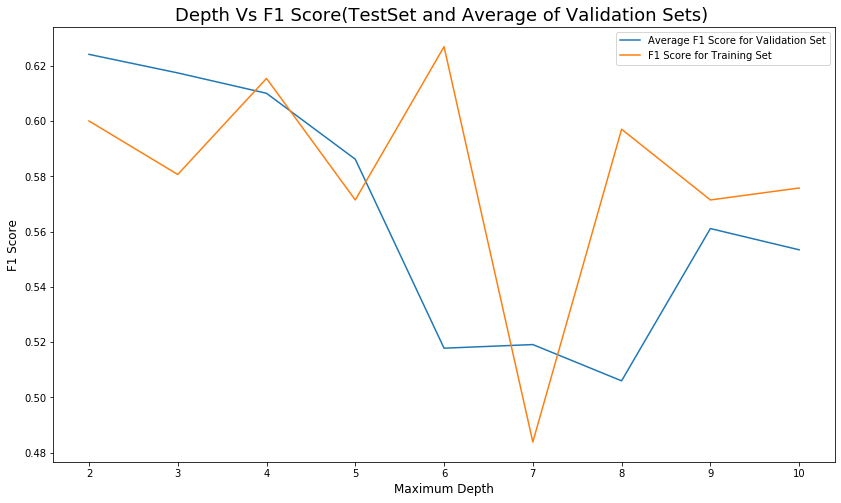

In [16]:
plt.figure(figsize=(14,8))
depth = list(range(2,11))

plt.plot(depth, averageValidationScores, label='Average F1 Score for Validation Set') # Plot training error over domain
testF1Scores = list(testF1ScoresWithoutValidation['F1-score (test)'])
plt.plot(depth, testF1Scores, label='F1 Score for Training Set') # Plot testing error over domain
plt.xlabel('Maximum Depth',fontsize=12) # Label x-axis
plt.ylabel('F1 Score',fontsize=12) # Label y-axis
plt.title('Depth Vs F1 Score(TestSet and Average of Validation Sets) ',fontsize=18) # Label y-axis
plt.legend() # Show plot labels as legend
plt.show()